In [1030]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from sklearn import model_selection, preprocessing
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score, train_test_split
color = sns.color_palette()
from scipy.stats import skew
%matplotlib inline

In [1031]:
train = pd.read_csv("train.csv", parse_dates=['timestamp']).drop(['id'],axis=1)
test = pd.read_csv("test.csv", parse_dates=['timestamp']).drop(['id'],axis=1)
macro= pd.read_csv("macro.csv", parse_dates=['timestamp'])

In [1032]:
macro_col=['timestamp', 'usdrub','rts','micex','micex_rgbi_tr','micex_cbi_tr','cpi','oil_urals']
macro=macro[macro_col] #using only those macro columns with greater than 100 unique values

In [1033]:
train = pd.merge(train,macro,on="timestamp", how ="left")

Splitting categorical and numeric features:

In [1034]:
feats_cat = train.select_dtypes(include = ["object"]).columns
feats_num = train.select_dtypes(exclude = ["object"]).columns
feats_num = feats_num.drop("timestamp")
train_num = train[feats_num]
train_cat = train[feats_cat]

In [1035]:
train_num = train_num.replace([np.inf, -np.inf], np.nan)
train_num = train_num.fillna(train_num.mean())

Log transforming to a normal distribution:

In [1036]:
train["price_doc"] = np.log1p(train["price_doc"]) # log transform price

get_skew = train_num.apply(lambda x: skew(x))
get_skew = get_skew[abs(get_skew) > 0.5] # assume skew >0.5 are skewed
skewed_feat = get_skew.index 
train_num[skewed_feat] = np.log1p(train_num[skewed_feat]) # converting skewed features to normal

In [1037]:
train_cat = pd.get_dummies(train_cat) #get dummy variables for categorical features

In [1038]:
train = pd.concat([train_num, train_cat], axis = 1)

In [1039]:
y = train.price_doc # getting the dependent variable

In [1040]:
train = train.drop(["price_doc"],axis=1) # dropping it from the predictor dataset

In [1041]:
xtrain, xtest, ytrain, ytest = train_test_split(train, y, test_size = 0.2, random_state = 0) #K-fold cross validation

In [1042]:
xtrain = scale(xtrain) #standardizing the features with mean 0 and unit variance
xtrain = pd.DataFrame(xtrain)
xtrain.columns = train.columns.values 

In [1043]:
xtest = scale(xtest) #standardizing the features with mean 0 and unit variance
xtest = pd.DataFrame(xtest)
xtest.columns = train.columns.values

In [1044]:
ytrain = scale(ytrain) #standardizing the response with mean 0 and unit variance
ytest = scale(ytest)

# Ridge regression

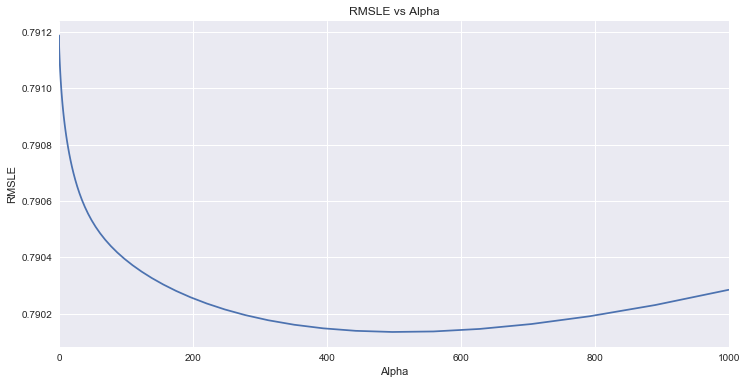

In [1089]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, xtrain, ytrain, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

model_ridge = Ridge()

alphas = np.logspace(-2,3,100)
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

plt.figure(figsize=(12,6))
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "RMSLE vs Alpha")
plt.xlabel("Alpha")
plt.ylabel("RMSLE")
plt.show()

In [1061]:
#Finding the tuning parameter
ridge = RidgeCV(alphas = np.logspace(-2,3,100)).fit(xtrain, ytrain)
alpha = ridge.alpha_

#Tuning the alpha
alpha = RidgeCV(alphas = [alpha*0.6, alpha * .75, alpha * .9, alpha, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], cv = 10).fit(xtrain, ytrain).alpha_

print("RMSE :", rmse_cv(ridge).mean())

('Ridge alpha: ', 308.71830358642637)
('RMSE :', 0.79037599936595382)


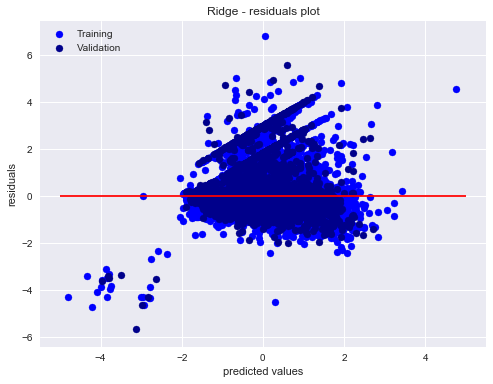

In [1062]:
#predicted values
ytrain_ridge = ridge.predict(xtrain)
ytest_ridge = ridge.predict(xtest)

#residual plot vs predicted values
plt.figure(figsize=(8,6))
plt.scatter(ytrain_ridge, ytrain_ridge - ytrain, c = "blue", label = "Training")
plt.scatter(ytest_ridge, ytest_ridge - ytest, c = "darkblue", label = "Validation")
plt.title("Ridge - residuals plot")
plt.xlabel("predicted values")
plt.ylabel("residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = -5, xmax = 5, color = "red")
plt.show()

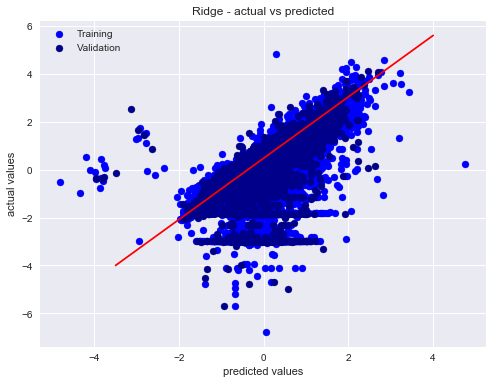

In [1066]:
plt.figure(figsize=(8,6))
plt.scatter(ytrain_ridge, ytrain, c = "blue", label = "Training")
plt.scatter(ytest_ridge, ytest, c = "darkblue", label = "Validation")
plt.title("Ridge - actual vs predicted")
plt.xlabel("predicted values")
plt.ylabel("actual values")
plt.legend(loc = "bottom right")
plt.plot([-3.5, 4], [-4, 5.6], c = "red")
plt.show()

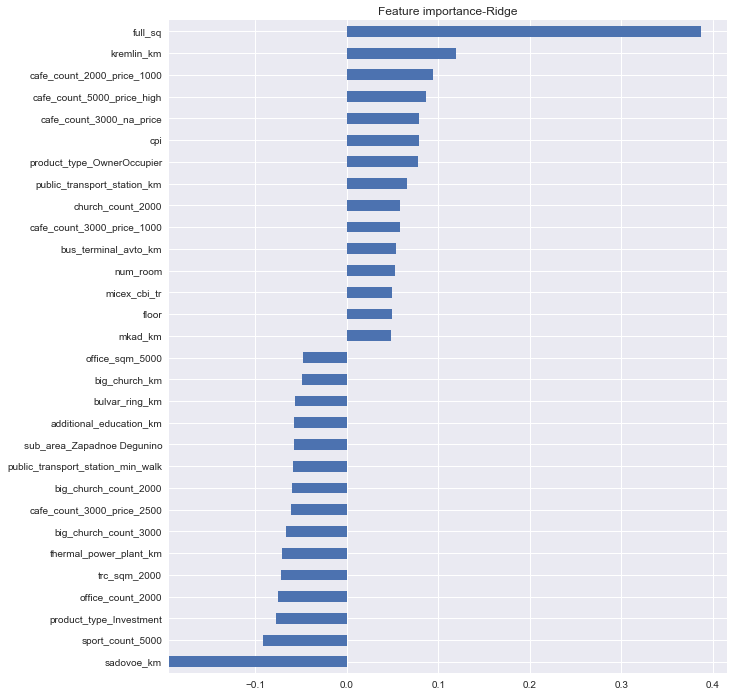

In [1068]:
#Getting the 30 most important features
plt.figure(figsize=(10,12))
coefs = pd.Series(ridge.coef_, index = xtrain.columns)

imp_coefs = pd.concat([coefs.sort_values().head(15),
                     coefs.sort_values().tail(15)])
imp_coefs.plot(kind = "barh")
plt.title("Feature importance-Ridge")
plt.show()

# Lasso regression

In [1083]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, xtrain, ytrain, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

model_lasso = Lasso()

('Lasso alpha: ', 0.013999999999999999)
('RMSE :', 0.79013623462778715)


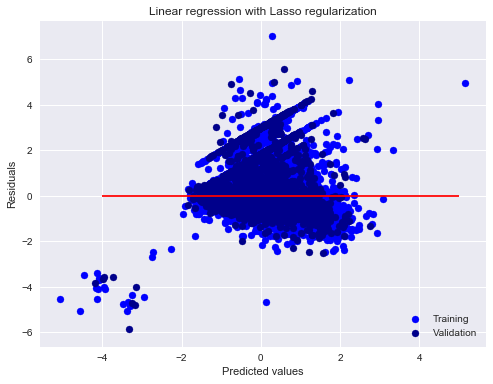

In [1086]:
lasso = LassoCV(alphas = np.logspace(-2,2,100), max_iter = 10000, cv = 3).fit(xtrain, ytrain)
alpha = lasso.alpha_

alpha = RidgeCV(alphas = [alpha*0.6, alpha * .75, alpha * .9, alpha, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], cv = 10).fit(xtrain, ytrain).alpha_

print("Lasso alpha: ", alpha)

print("RMSE :", rmse_cv(ridge).mean())

y_train_las = lasso.predict(xtrain)
y_test_las = lasso.predict(xtest)

# Plot residuals
plt.figure(figsize=(8,6))
plt.scatter(y_train_las, y_train_las - ytrain, c = "blue", label = "Training")
plt.scatter(y_test_las, y_test_las - ytest, c = "darkblue", label = "Validation")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "lower right")
plt.hlines(y = 0, xmin = -4, xmax = 5, color = "red")
plt.show()

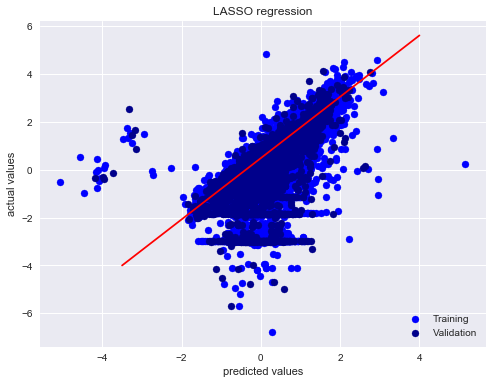

In [1087]:
# Plot predictions
plt.figure(figsize=(8,6))
plt.scatter(y_train_las, ytrain, c = "blue",  label = "Training")
plt.scatter(y_test_las, ytest, c = "darkblue", label = "Validation")
plt.title("LASSO regression")
plt.xlabel("predicted values")
plt.ylabel("actual values")
plt.legend(loc = "lower right")
plt.plot([-3.5, 4], [-4, 5.6], c = "red")
plt.show()

95 features selected; 363features eliminated


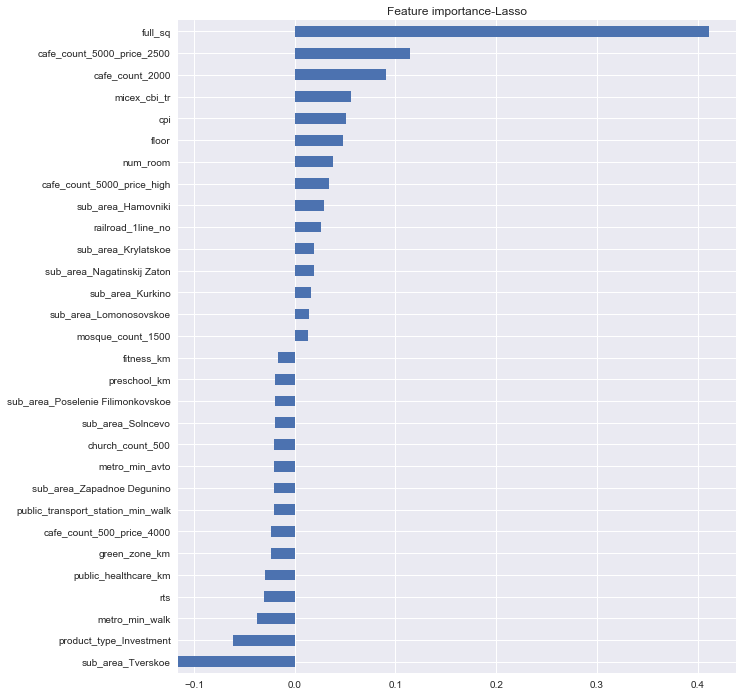

In [1088]:
# Plot important coefficients
plt.figure(figsize=(10,12))
coefs = pd.Series(lasso.coef_, index = xtrain.columns)
print(str(sum(coefs != 0)) + " features selected; " +  \
      str(sum(coefs == 0)) + "features eliminated")
imp_coefs = pd.concat([coefs.sort_values().head(15),
                     coefs.sort_values().tail(15)])
imp_coefs.plot(kind = "barh")
plt.title("Feature importance-Lasso")
plt.show()